In [1]:
import functools
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tqdm import trange

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Analyze the embeddings

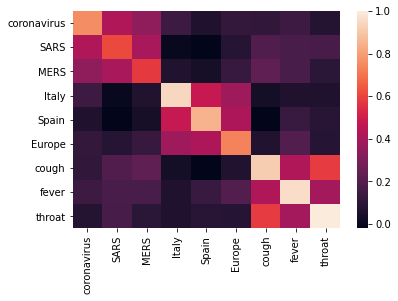

In [2]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels = labels, yticklabels = labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')
embeddings = module(queries)

plot_correlation(queries, embeddings)

### SciCite: Citation Intent Classification

Use the SciCite Dataset

In [3]:
builder = tfds.builder(name = 'scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split = ('train', 'validation', 'test'),
    as_supervised = True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incompleteYLKHH6/scicite-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incompleteYLKHH6/scicite-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incompleteYLKHH6/scicite-test.tfrecord


Dataset scicite downloaded and prepared to /root/tensorflow_datasets/scicite/1.0.0. Subsequent calls will reuse this data.


In [4]:
NUM_EXAMPLES =   10

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))


pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
    LABEL_NAME: [label2str(x) for x in data[1]]
})

,string,label
0,The finding that BMI is closely related to TBF...,result
1,The average magnitude of the NBR increases wit...,background
2,It has been reported that NF-κB activation can...,result
3,", 2008; Quraan and Cheyne, 2008; Quraan and Ch...",background
4,"5B), but, interestingly, they shared conserved...",background
5,Some investigators have noted an association o...,background
6,"In our previous study, it is documented that b...",background
7,These subjects have intact cognitive function ...,background
8,Another study reported improved knee function ...,background
9,C. Data Analysis Transcription Speech samples ...,method


### Training a citaton intent classifier

In [5]:
EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3'  
TRAINABLE_MODULE = False  

hub_layer = hub.KerasLayer(EMBEDDING, input_shape = [], 
                           dtype = tf.string, trainable = TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               17301632  
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 17,302,019
Trainable params: 387
Non-trainable params: 17,301,632
_________________________________________________________________


In [6]:
EPOCHS =   35
BATCH_SIZE = 32

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs = EPOCHS,
                    validation_data = validation_data.batch(BATCH_SIZE),
                    verbose = 1)

Epoch 1/35
257/257 [==============================] - 2s 8ms/step - loss: 0.8746 - accuracy: 0.6073 - val_loss: 0.7685 - val_accuracy: 0.6867
Epoch 2/35
257/257 [==============================] - 2s 7ms/step - loss: 0.6950 - accuracy: 0.7152 - val_loss: 0.6736 - val_accuracy: 0.7358
Epoch 3/35
257/257 [==============================] - 2s 7ms/step - loss: 0.6273 - accuracy: 0.7525 - val_loss: 0.6301 - val_accuracy: 0.7489
Epoch 4/35
257/257 [==============================] - 2s 7ms/step - loss: 0.5925 - accuracy: 0.7685 - val_loss: 0.6053 - val_accuracy: 0.7631
Epoch 5/35
257/257 [==============================] - 2s 7ms/step - loss: 0.5719 - accuracy: 0.7773 - val_loss: 0.5913 - val_accuracy: 0.7664
Epoch 6/35
257/257 [==============================] - 2s 7ms/step - loss: 0.5581 - accuracy: 0.7829 - val_loss: 0.5826 - val_accuracy: 0.7762
Epoch 7/35
257/257 [==============================] - 2s 7ms/step - loss: 0.5488 - accuracy: 0.7880 - val_loss: 0.5720 - val_accuracy: 0.7795
Epoch 

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize = (10,10), facecolor = '#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

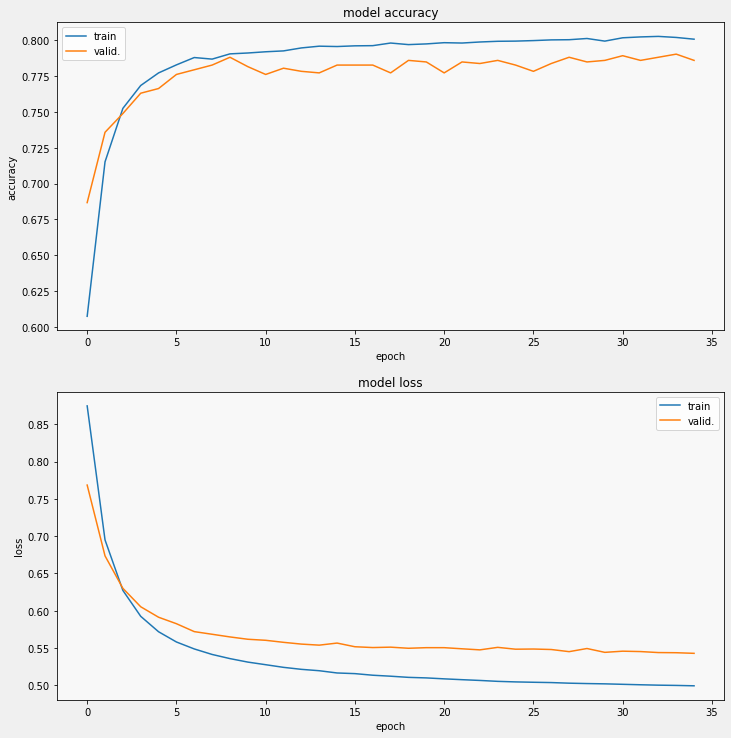

In [8]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [9]:
results = model.evaluate(test_data.batch(512), verbose = 2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.5330 - accuracy: 0.7934
loss: 0.533
accuracy: 0.793


In [10]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [label2str(x) for x in model.predict_classes(prediction_texts)]


pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,string,label,prediction
0,"The diffraction grating, LED, and split detect...",background,method
1,Our ideas are based on a previous paper [4] de...,background,method
2,Our finding is consistent with the literature ...,result,result
3,Test scores from each of the cognitive domains...,method,method
4,The optimization algorithm was set to maximize...,method,method
5,To quantify the extent of substitution saturat...,method,method
6,Examples of gesture control are based on the e...,method,method
7,The identification of these features has been ...,method,background
8,Postulated mechanisms for observed effects of ...,background,background
9,The right inferior phrenic artery is the most ...,background,background
